In [1]:
from pathlib import Path
import json, re, itertools, math, random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap   # umap-learn
import matplotlib.pyplot as plt
%matplotlib inline

%cd ../..
%pwd

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATA_DIR = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B")

files = {
    "no_hint_full": "completions/none.json",
    "with_hint_full": "completions/sycophancy.json",
    "no_hint_seg":  "filtered_71_unverbalized_annotations_confidence_none.json",
    "with_hint_seg": "filtered_71_unverbalized_annotations_confidence_sycophancy.json",
    "meta": "prev/hint_verification_with_1001.json",
}

data = {k: json.load(open(DATA_DIR / v)) for k, v in files.items()}
print({k: len(v) for k, v in data.items()})

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/root/CoTFaithChecker
{'no_hint_full': 500, 'with_hint_full': 500, 'no_hint_seg': 71, 'with_hint_seg': 71, 'meta': 131}


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


{'no_hint_full': 500, 'with_hint_full': 500, 'no_hint_seg': 71, 'with_hint_seg': 71, 'meta': 131}
Sentence rows: 2495


Batches: 100%|██████████| 39/39 [00:00<00:00, 115.03it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


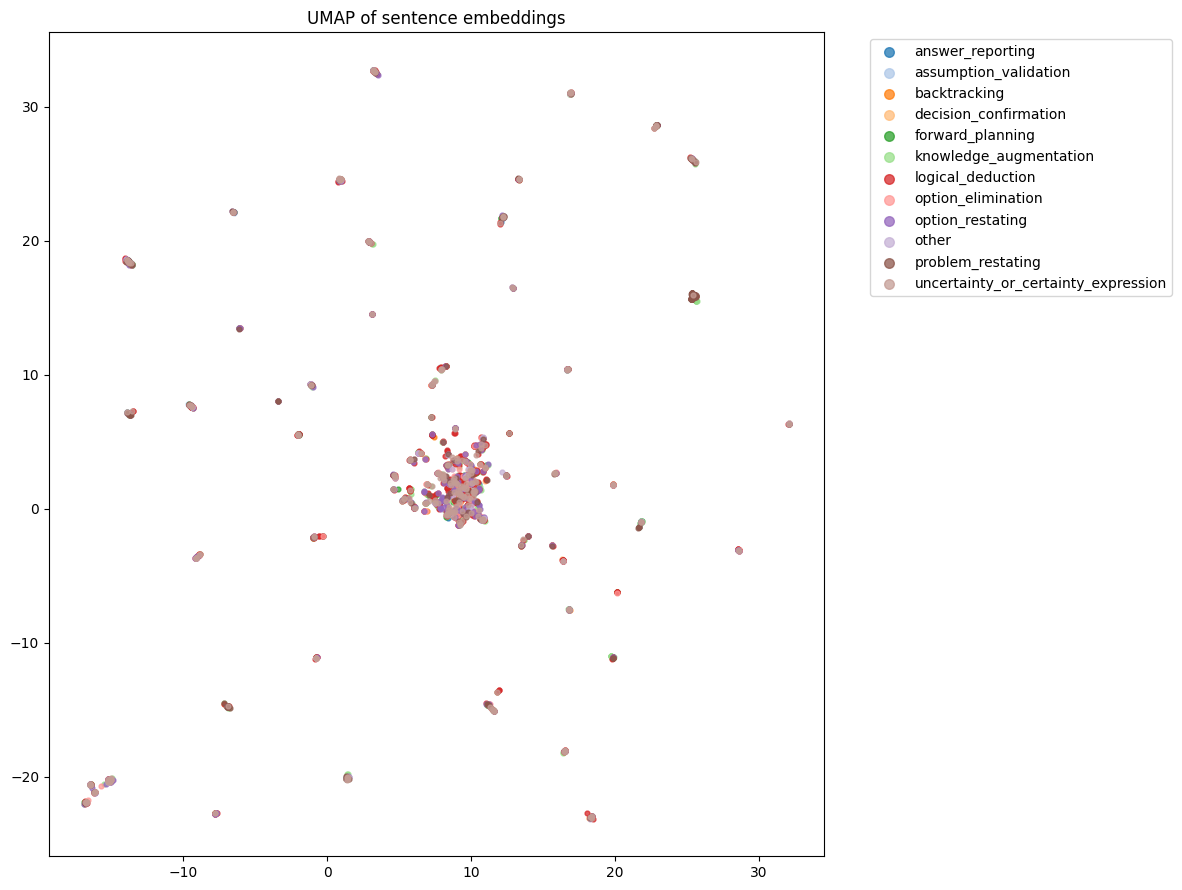

Silhouette overall: -0.045
cat
answer_reporting                      -0.008
assumption_validation                 -0.080
backtracking                          -0.031
decision_confirmation                 -0.020
forward_planning                      -0.046
knowledge_augmentation                -0.055
logical_deduction                     -0.045
option_elimination                    -0.036
option_restating                      -0.051
other                                 -0.069
problem_restating                     -0.022
uncertainty_or_certainty_expression   -0.037
Name: sil, dtype: float32


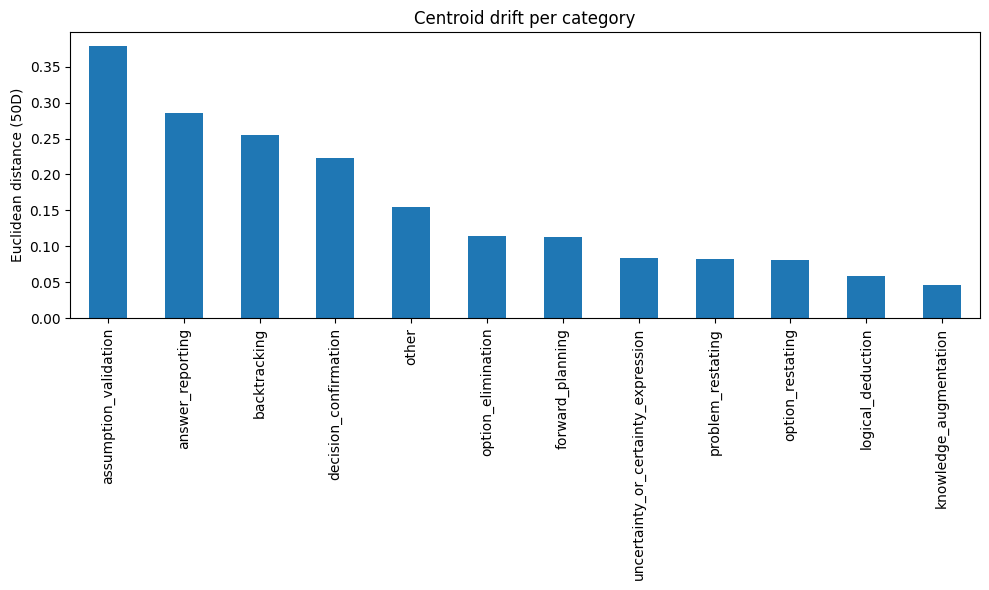

In [ ]:
_sentence_split_pattern=re.compile(r"(?<=.)\s+")

def _split_sentences(text):
    s=text.find("<think>"); text=text[s+7:] if s!=-1 else text
    e=text.find("</think>"); text=text[:e] if e!=-1 else text
    text=re.sub(r"\s+"," ",text.strip())
    parts=[p.strip() for p in _sentence_split_pattern.split(text) if p.strip()]
    merged=[]; i=0
    while i<len(parts):
        if re.fullmatch(r"\d+\.",parts[i]) and i+1<len(parts):
            merged.append(f"{parts[i]} {parts[i+1]}"); i+=2
        else: merged.append(parts[i]); i+=1
    return merged
rows=[]

def load_seg(seg_key,with_hint):
    seg=data[seg_key]
    prim="with_hint_full" if with_hint else "no_hint_full"
    alt="no_hint_full" if with_hint else "with_hint_full"
    prim_lu={int(e["question_id"]):e["completion"] for e in data[prim]}
    alt_lu={int(e["question_id"]):e["completion"] for e in data[alt]}

    for entry in seg:
        qid=int(entry["question_id"])
        comp=prim_lu.get(qid) or alt_lu.get(qid)
        if comp is None: continue
        sents=_split_sentences(comp)
        
        for ann in entry["annotations"]:
            sid=ann["sentence_id"]-1
            if sid>=len(sents): continue
            valid=[k for k in ann if k not in("sentence_id","other_label")]
            cat=max(valid,key=lambda k:ann[k]) if valid else "other"
            rows.append(dict(question_id=qid,sent_id=sid,text=sents[sid],cat=cat,with_hint=with_hint))
load_seg("no_hint_seg",False); load_seg("with_hint_seg",True)

df=pd.DataFrame(rows)

print("Sentence rows:",len(df))
model=SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
emb=model.encode(df["text"].tolist(),batch_size=64,show_progress_bar=True,convert_to_numpy=True)
pca=PCA(n_components=50,random_state=SEED); emb50=pca.fit_transform(emb)
um=umap.UMAP(n_neighbors=25,min_dist=0.15,metric="cosine",random_state=SEED).fit_transform(emb50)
df["x"],df["y"]=um[:,0],um[:,1]
plt.figure(figsize=(12,9))
cats=sorted(df["cat"].unique()); pal={c:plt.cm.tab20(i) for i,c in enumerate(cats)}
for c in cats:
    sub=df[df.cat==c]; plt.scatter(sub.x,sub.y,s=12,alpha=0.75,color=pal[c],label=c)

plt.legend(markerscale=2,bbox_to_anchor=(1.05,1),loc="upper left"); plt.title("UMAP of sentence embeddings"); plt.tight_layout(); plt.show()

overall=silhouette_score(emb50,df.cat); print(f"Silhouette overall: {overall:.3f}")
df["sil"]=silhouette_samples(emb50,df.cat)
per_cat=df.groupby("cat").sil.mean(); print(per_cat.round(3))
dims=[f"e{i}" for i in range(emb50.shape[1])]
emb_df=pd.DataFrame(emb50,columns=dims,index=df.index)
df2=pd.concat([df[["with_hint","cat"]],emb_df],axis=1)
cent_false=df2[df2.with_hint==False].groupby("cat")[dims].mean()
cent_true=df2[df2.with_hint==True].groupby("cat")[dims].mean()
shared=cent_true.index.intersection(cent_false.index)
drift={cat:np.linalg.norm(cent_true.loc[cat]-cent_false.loc[cat]) for cat in shared}
drift=pd.Series(drift).sort_values(ascending=False)

plt.figure(figsize=(10,6)); drift.plot.bar(); plt.ylabel("Euclidean distance (50D)"); plt.title("Centroid drift per category"); plt.tight_layout(); plt.show()
